# ITCS 4152/5152 Assignment3
**Due date: 11:59 pm EST on Feb 27, 2023 (Fri.)**

---
In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your UNC Charlotte (*.uncc.edu) account for coding and Google Drive to save your results.


## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Using SIFT in OpenCV 3.x.x in Colab
---
The default version of OpenCV in Colab is 3.4.3. If we use SIFT method directly, typically we will get this error message:

```
error: OpenCV(3.4.3) /io/opencv_contrib/modules/xfeatures2d/src/sift.cpp:1207: error: (-213:The function/feature is not implemented) This algorithm is patented and is excluded in this configuration; Set OPENCV_ENABLE_NONFREE CMake option and rebuild the library in function 'create'

```

One simple way to use the OpenCV in-built function `SIFT` in Colab is to switch the version to the one from 'contrib'. Below is an example of switching OpenCV version:

1. Run the following command in one section in Colab, which has already been included in this assignment:
```
pip install opencv-contrib-python
```
2. Restart runtime by
```
Runtime -> Restart Runtime
```

Then you should be able to use use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object, whose functions are listed at http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html

## Some Resources
---
In addition to the tutorial document, the following resources can definitely help you in this homework:
- http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html
- http://docs.opencv.org/3.1.0/da/df5/tutorial_py_sift_intro.html
- http://docs.opencv.org/3.0-beta/modules/xfeatures2d/doc/nonfree_features.html?highlight=sift#cv2.SIFT
- http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_geometric_transformations/py_geometric_transformations.html





In [55]:
#pip install opencv-contrib-python

In [56]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import itertools
import time
import zipfile
import torch
import torchvision
import gc
import pickle
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
import os

print(cv2.__version__) # verify OpenCV version

4.6.0


In [57]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [58]:
# Mount your google drive where you've saved your assignment folder
# from google.colab import drive
# drive.mount('/content/gdrive')
from google.colab import drive
os.chdir("/content/gdrive/My Drive/Ayalasomayajula_Ramakanth_801310383_assignment3/")

In [59]:
# # Replace '------' with the path such that "Surname_Givenname_UNCCID_assignment3" is your working directory
# cd '/content/gdrive/My Drive/------'

## Problem 1: Image Classification with Bag of SIFT Representation + SVM Classifer

## Description
---
In this problem, we will examine the task of image classification using bags of quantized local features and linear classifiers learned by support vector machines. We will implement a basic bag of words model and
classify images into one of 10 categories by training and testing on **a small subset** of **miniImagenet** dataset (downloaded from https://awesomeopensource.com/project/oscarknagg/few-shot).

Bag of words models are a popular technique for image classification inspired by
models used in natural language processing. The model ignores or downplays word
arrangement (spatial information in the image) and classifies based on a
histogram of the frequency of visual words. The visual word "vocabulary" is
established by clustering a large corpus of local features. See Szeliski chapter
14.4.1 for more details on category recognition with quantized features. In
addition, 14.3.2 discusses vocabulary creation and 14.1 covers classification
techniques.

## Data Preparation
----

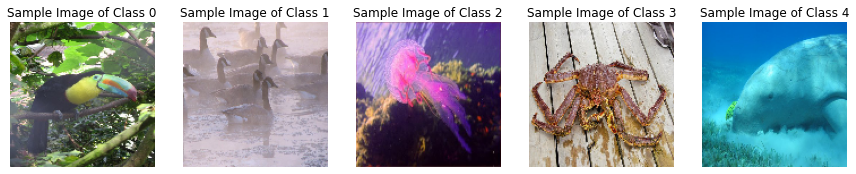

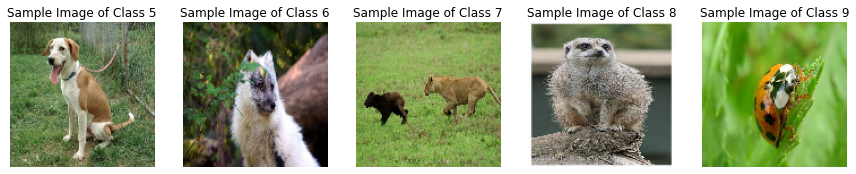

In [60]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict_train = pickle.load(fo, encoding='bytes')
        dict_test = pickle.load(fo, encoding='bytes')
    return dict_train, dict_test

# load data from pickle files and sample a small subset for this homework
train_data_dict, test_data_dict = unpickle('miniImageNet.pkl') 
train_label = train_data_dict['labels']  
train_data = train_data_dict['data']  

test_label = test_data_dict['labels']   
test_data = test_data_dict['data'] 

# reshape data
train_data = [d.reshape(3, 128, 128).transpose(1,2,0) for d in train_data]
test_data = [d.reshape(3, 128, 128).transpose(1,2,0) for d in test_data]

# plot 10 training images from 10 classes
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title('Sample Image of Class {}'.format(i))
    plt.imshow(cv2.cvtColor(train_data[500*i], cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()
plt.figure(figsize=(15, 3))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title('Sample Image of Class {}'.format(i+5))
    plt.imshow(cv2.cvtColor(train_data[500*(i+5)], cv2.COLOR_BGR2RGB))
    plt.axis("off")
plt.show()

## Problem 1.a: Bag of SIFT Representation 
{50 points}
Before we can represent our training and testing images as bag of
feature histograms, we first need to establish a vocabulary of visual words. We
will form this vocabulary by sampling many local features from our training set
(10's or 100's of thousands) and then cluster them with k-means. The number of
k-means clusters is the size of our vocabulary and the size of our features. For
example, you might start by clustering many SIFT descriptors into k=50 clusters.
This partitions the continuous, 128 dimensional SIFT feature space into 50
regions. For any new SIFT feature we observe, we can figure out which region it
belongs to as long as we save the centroids of our original clusters. Those
centroids are our visual word vocabulary. 

Now we are ready to represent our training and testing images as histograms of
visual words. For each image we will densely sample many SIFT descriptors.
Instead of storing hundreds of SIFT descriptors, we simply count how many SIFT
descriptors fall into each cluster in our visual word vocabulary. This is done
by finding the nearest neighbor k-means centroid for every SIFT feature. Thus,
if we have a vocabulary of 50 visual words, and we detect 200 distinct SIFT
features in an image, our bag of SIFT representation will be a histogram of 50
dimensions where each bin counts how many times a SIFT descriptor was assigned
to that cluster. The total of all the bin-counts is 200. The histogram should be
normalized so that image size does not dramatically change the bag of features
magnitude.


**Note**: 
- Instead of using SIFT to detect invariant keypoints which is time-consuming,
  you are recommended to **densely sample keypoints** in a grid with certain step
  size (sampling density) and scale. 
- There are many design decisions and free parameters for the bag of SIFT
  representation (number of clusters, sampling density, sampling scales, SIFT
  parameters, etc.) so accuracy might vary.



**Hints**:
- Use [KMeans in Sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)
  to do clustering and find the nearest cluster centroid for each SIFT feature;
- Use `cv2.xfeatures2d.SIFT_create()` to create a SIFT object;
- Use [`cv2.Keypoint()`](https://docs.opencv.org/3.0-beta/modules/core/doc/basic_structures.html?highlight=keypoint#keypoint) to generate key points;
- Use `sift.compute()` to compute SIFT descriptors given densely sampled keypoints.

- Be mindful of RAM usage. Try to make the code more memory efficient, otherwise it could easily exceed RAM limits in Colab, at which point your session will crash.
- If your RAM is going to run out of space, use [gc.collect()](https://docs.python.org/3/library/gc.html) for the garbage collector to collect unused objects in  memory to free some space.
- Store data or features as NumPy arrays instead of lists. Computation on NumPy arrays is much more efficient than lists.

In [61]:
import cv2
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn import neighbors

np.random.seed(65)

def Keypoints_Detection(shape, stride, size):
    '''Create arrays of x and y coordinates using np.linspace'''
    x_cord = np.linspace(stride/2, shape[1]-stride/2, num=shape[1]//stride, dtype=np.float32)
    y_cord = np.linspace(stride/2, shape[0]-stride/2, num=shape[0]//stride, dtype=np.float32)
    '''Use itertools.product to generate all combinations of x and y coordinates'''
    kp_cords = itertools.product(x_cord, y_cord)
    '''Create a list of cv2.KeyPoint objects from the coordinate pairs'''
    key_pts = [cv2.KeyPoint(x, y, size) for (x, y) in kp_cords]
    return key_pts

def Vocabulary_Extraction(raw_data, key_pt, k):
    '''SIFT detector using SIFT_create()'''
    sift_cr = cv2.xfeatures2d.SIFT_create()
    '''Finding the descriptors for the keypoints'''
    desc_lst = [sift_cr.compute(a, key_pt)[1] for a in raw_data]
    '''Stacking the descriptors into a list'''
    desc = np.vstack(desc_lst)
    '''Cluster descriptors into 'k' clusters using KMeans'''
    k_means_cluster = KMeans(n_clusters=k, random_state=0).fit(desc)
    vocabulary_extracted = k_means_cluster.cluster_centers_
    '''Returning the centers of 'k' clusters as vocabulary_extracted'''
    return vocabulary_extracted

def Feature_Extraction(raw_data, vocabulary, key_point):
    '''SIFT detector using SIFT_create()'''
    sift = cv2.xfeatures2d.SIFT_create()
    features_lst = []
    for img in raw_data:
        '''Using sift detector compute method to find the keypoints and descriptors'''
        kp, des = sift.compute(img, key_point)
        '''Finding the minimum Euclidian distance here'''
        dist = np.argmin(np.linalg.norm(des[:, np.newaxis] - vocabulary[np.newaxis, :], axis=2), axis=1)
        '''Computing the histogram to a 1D array which has thew frequency of each visual word'''
        histo_gram, p = np.histogram(dist, bins=len(vocabulary), range=(0, len(vocabulary)))
        '''Storing this in the features_lst list'''
        features_lst.append(histo_gram)
    feats = np.vstack(features_lst)
    '''Creating a 2D array'''
    feats = feats.astype(np.float32) / np.sum(feats, axis=1, keepdims=True)
    return feats

skp = Keypoints_Detection(train_data[0].shape, 28, 8)
vocabulary = Vocabulary_Extraction(train_data, skp, 50)  
train_feat = Feature_Extraction(train_data, vocabulary, skp)
test_feat = Feature_Extraction(test_data, vocabulary, skp)

##########-------END OF CODE-------##########
# this block should generate 
# train_feat and test_feat corresponding to train_data and test_data

/usr/local/lib/python3.8/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


## Problem 1.b: one-vs-all SVMs
{50 points}
You do not have to implement the support vector machine. However, linear
classifiers are inherently binary and we have a 10-way classification problem
(the library has handled it for you). To decide which of 10 categories a test
case belongs to, you will train 10 binary, one-vs-all SVMs. One-vs-all means
that each classifier will be trained to recognize 'bird' vs 'non-bird',
'cat' vs 'non-cat', etc. All 10 classifiers will be evaluated on each
test case and the classifier which is most confidently positive "wins". E.g. if
the 'cat' classifier returns a score of -0.2 (where 0 is on the decision
boundary), and the 'bird' classifier returns a score of -0.3, and all of the
other classifiers are even more negative, the test case would be classified as a
'cat' even though none of the classifiers put the test case on the positive
side of the decision boundary. When learning an SVM, you have a free parameter
**C** which controls how strongly regularized the model is. Your
accuracy will be very sensitive to **C**, so be sure to try many values.


**Hints**:
- Use SVM in
  [Sklearn](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.svm)
  (recommended) or
  [OpenCV](https://docs.opencv.org/3.0-alpha/modules/ml/doc/support_vector_machines.html)
  to do training and prediction.

In [62]:
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC

def SVM_Training(X, Y):
    #clf = LinearSVC(C=0.9, random_state=42)
    #clf = SGDClassifier(loss='hinge', penalty='l2', alpha=0.1, random_state=42)
    #clf = RandomForestClassifier(n_estimators=100, random_state=42)
    '''Using Radial Basis Function to initialize the SVM Classifier'''
    clf = SVC(kernel='rbf', gamma='scale', C=0.85)
    clf.fit(X, Y)
    return clf

def SVM_Prediction(clf, X):
    '''Predicting thr class labels based on the previously trained SVM classifier'''
    predict = clf.predict(X)
    return predict

clf = SVM_Training(train_feat, train_label)
prediction = [-1]*len(test_feat)
for i in range(len(test_feat)):
    prediction[i] = SVM_Prediction(clf, np.reshape(test_feat[i],(1,-1)))

test_label_pred = np.reshape(np.array(prediction),(-1,))

##########-------END OF CODE-------##########
accuracy = sum(np.array(test_label_pred) == test_label) / float(len(test_label))
print("The accuracy of Bag of SIFT Representation + one-vs-all SVMs model is {:.2f}%".format(accuracy*100))

'''
Refernces:
https://numpy.org/doc/stable/reference/generated/numpy.linspace.html
https://docs.python.org/3/library/itertools.html
https://www.geeksforgeeks.org/python-itertools-product/
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
https://stackoverflow.com/questions/45234336/value-at-kmeans-cluster-centers-in-sklearn-kmeans
https://numpy.org/doc/stable/reference/generated/numpy.vstack.html
https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html
https://numpy.org/doc/stable/reference/generated/numpy.argmin.html
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.astype.html
https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html
https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
https://scikit-learn.org/stable/tutorial/basic/tutorial.html
'''

The accuracy of Bag of SIFT Representation + one-vs-all SVMs model is 31.90%


## Submission guidelines
---
Please submit a pdf file that includes a ***google shared link***(explained in the next paragraph) and the ***a copy paste of the Assignment solutions*** through canvas. This pdf file should be named as **Surname_Givenname_UNCCID_assignment*.pdf** (example: Jordan_Michael_800134567_assignment1.pdf for this assignment). This pdf will be used for a similarity checking of your codes.

To generate the ***google shared link***, first create a folder named ***Surname_Givenname_UNCCID_hw*.*** (example: Jordan_Michael_800134567_assignment1 for this assignment) in your Google Drive with your UNCC account. The structure of the files in the folder should be exactly the same as the one you downloaded. For instance in this homework:

```
Surname_Givenname_UNCCID_assignment3       
        |---SourceImages
        |---[Your_code].ipynb
```
Note that this folder should be in your Google Drive with your UNCC account.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter TA's emails: ***psingire@uncc.edu*** and ***sbirajda@uncc.edu***. Make sure that TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box.

Note that in google colab, we will only grade the version of the code right before the timestamp of the submission made in canvas. 

Regarding copy-pasting the assignment solutions, just copy-paste the code snippet you are writing in this Jupyter notebook. This generated pdf file will allow us to have access to your assigment solutions through the google shared link and perform a plagiarism checking on your designed solutions.

Extract the downloaded .zip file to a folder of your preference. The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_UNCCID_assignment1' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs.


-- DO NOT change the folder structure, please just fill in the blanks. <br>

You are encouraged to post and answer questions on Canvas. Please ask questions on Canvas and send emails only for personal issues.

If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have THREE days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.